## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# wipe all solutions in the directory
all_solutions = glob.glob('../temp/FITNESS_SOLUTION_*')
all_generations = glob.glob('../temp/GENERATION_*')
# for i in all_solutions:
#     os.remove(i)
# for j in all_generations:
#     os.remove(j)


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

## Read Inp File

In [4]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    INP_FILE_PATH = r"../data/Real_Synthetic_Net.inp" 
    TEMP_DIR = "../temp/"
    PLOTS_DIR = "../plots"
    FUNCTION_INPUTS = None
    DESIRED_OUTPUT = None

In [5]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
        
        self.node = node
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list, path:str, name:str):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
        

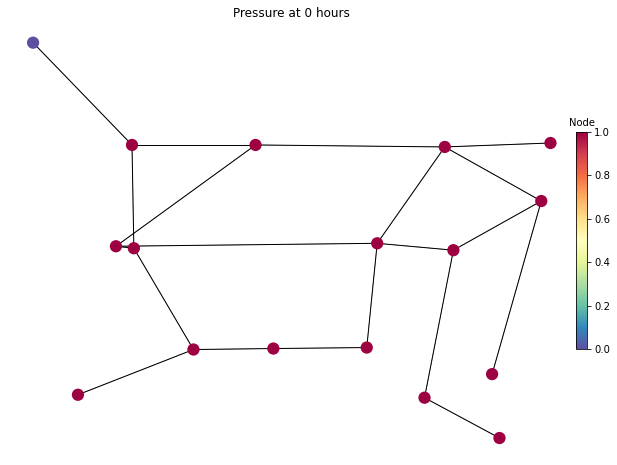

In [6]:
# Instantiate the pygad optimization class
water_model = WaterLeakModel(node='N6')
water_model.num_generations = 100

# Add leak and simulate
wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
node = wn.get_node('N6')
node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=.5)
water_model.simulate(wn, plot_graph=True)

water_model.FUNCTION_INPUTS = 0.5
water_model.DESIRED_OUTPUT = node.head - node.elevation

In [7]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
    results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    output = pressure.loc[:,'N6']
    demands=results.node['demand']
    output_demand = demands.loc[:,'N6']

    fitness = 1.0 / (np.abs(output - water_model.DESIRED_OUTPUT) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'OUTPUT':list(output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(output_demand) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model.TEMP_DIR}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [8]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model.TEMP_DIR}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [9]:
# Instantiate the pygad optimization class
ga_instance = pygad.GA(num_generations=water_model.num_generations,
                       num_parents_mating=water_model.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model.sol_per_pop,
                       num_genes=water_model.num_genes,
                       init_range_low=water_model.init_range_low,
                       init_range_high=water_model.init_range_high,
                       parent_selection_type=water_model.parent_selection_type,
                       keep_parents=water_model.keep_parents,
                       crossover_type=water_model.crossover_type,
                       mutation_type=water_model.mutation_type,
                       mutation_num_genes=water_model.mutation_num_genes,
                       callback_generation=callback_generation)

In [10]:
ga_instance.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |==================| 49.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |==================| 22.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 26.528 |==================| 79.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 26.542 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 419.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 26.539 |==================| 710.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |==================| 13.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.199 |===========| 26.428 |==================| 8.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.121 |===========| 26.441 |==================| 10.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.199 |===========| 26.428 |==================| 8.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.121 |===========| 26.441 |==================| 10.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |==================| 24.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 26.421 |==================| 8.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |==================| 45.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 26.49 |==================| 19.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 26.423 |==================| 8.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.615 |==================| 13.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 26.522 |==================| 54.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |==================| 9.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |==================| 9.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 26.522 |==================| 54.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |==================| 9.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |==================| 9.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |==================| 430.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 26.463 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |==================| 9.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |==================| 9.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |==================| 430.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.984 |===========| 26.463 |==================| 12.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 26.565 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |==================| 20.589 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 26.391 |==================| 6.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.401 |==================| 7.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 26.492 |==================| 20.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==================| 28.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |==================| 6.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 26.391 |==================| 6.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.401 |==================| 7.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 26.492 |==================| 20.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==================| 28.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |==================| 6.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |==================| 50.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.589 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 26.451 |==================| 11.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 26.445 |==================| 10.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.476 |==================| 15.652 |==========
Generation = 4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |==================| 273.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.241 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 26.445 |==================| 10.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.476 |==================| 15.652 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |==================| 273.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.241 |===========| 26.422 |==================| 8.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.476 |==================| 15.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 26.424 |==================| 8.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.549 |==================| 121.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 26.477 |==================| 15.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 26.533 |==================| 133.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 26.477 |==================| 15.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 26.533 |==================| 133.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 26.41 |==================| 7.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 26.477 |==================| 15.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 26.533 |==================| 133.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 26.41 |==================| 7.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |==================| 12008.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 26.567 |==================| 37.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |==================| 505.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |==================| 12.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |==================| 19.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 26.517 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |==================| 505.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |==================| 12.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |==================| 19.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 26.517 |==================| 42.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 26.407 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 167.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 27.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 167.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 27.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 41.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 167.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 27.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 41.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |==================| 41.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 26.395 |==================| 6.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 26.536 |==================| 226.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 26.48 |==================| 16.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.438 |==================| 9.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.457 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 26.395 |==================| 6.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 26.536 |==================| 226.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 26.48 |==================| 16.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.438 |==================| 9.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |==================| 33.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 26.589 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 26.617 |==================| 13.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |==================| 32.326 |==========
Generation = 9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 76.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.667 |===========| 26.514 |==================| 37.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 26.571 |==================| 32.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |==================| 32.326 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 76.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.667 |===========| 26.514 |==================| 37.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 26.571 |==================| 32.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 26.565 |==================| 40.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 26.496

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 26.515 |==================| 39.48 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.049 |===========| 26.453 |==================| 11.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.023 |===========| 26.457 |==================| 12.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 156.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.023 |===========| 26.457 |==================| 12.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 156.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |==================| 19.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 26.443 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |==================| 19.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 26.443 |==================| 10.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.538 |==================| 525.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 26.459 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 67.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 167.726 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.724 |===========| 26.505 |==================| 28.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 26.476 |==================| 15.448 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 26.555 |==================| 66.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.127 |===========| 26.44 |==================| 9.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 26.506 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 26.555 |==================| 66.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.127 |===========| 26.44 |==================| 9.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 26.506 |==================| 29.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.864 |===========| 26.483 |==================| 17.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.762 |===========| 26.499 |==================| 24.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.071 |===========| 26.449 |==================| 10.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |==================| 13.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 26.511 |==================| 34.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 26.456 |==================| 11.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 2071.247 |==========
Generation = 12
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 26.456 |==================| 11.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 2071.247 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 26.509 |==================| 32.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 26.391 |==================| 6.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 26.52 |==================| 49.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 26.596 |==================| 17.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |==================| 22.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 197.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |==================| 21.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |==================| 22.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 197.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |==================| 21.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 26.494 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 197.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |==================| 21.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 26.494 |==================| 21.647 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |==================| 14.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.246 |===========| 26.421 |==================| 8.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.603 |==================| 15.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.209 |===========| 26.427 |==================| 8.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.246 |===========| 26.421 |==================| 8.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.603 |==================| 15.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.209 |===========| 26.427 |==================| 8.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 26.516 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 74.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |==================| 20.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 26.51 |==================| 32.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |==================| 9.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |==================| 65.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 26.54 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |==================| 9.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |==================| 65.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 26.54 |==================| 9643.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 26.465 |==================| 13.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |==================| 17.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 26.406 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 26.54 |==================| 9643.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 26.465 |==================| 13.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |==================| 17.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 26.406 |==================| 7.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.129 |===========| 26.44 |==================| 9.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 26.408 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 26.458 |==================| 12.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 26.451 |==================| 11.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 26.45 |==================| 11.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 26.446 |==================| 10.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 |==================| 23.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.996 |===========| 26.461 |==================| 12.658 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.143 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 26.45 |==================| 11.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 26.446 |==================| 10.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 |==================| 23.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.996 |===========| 26.461 |==================| 12.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.143 |===========| 26.438 |==================| 9.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.667 |===========| 26.514 |==================| 37.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 26.459 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |==================| 9.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 26.533 |==================| 140.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.426 |===========| 26.391 |==================| 6.706 |==========
Generation = 17
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==================| 19.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 26.489 |==================| 19.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 |==================| 15.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 26.45

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.426 |===========| 26.391 |==================| 6.706 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==================| 19.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 26.489 |==================| 19.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 |==================| 15.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 26.452 |==================| 11.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.211 |===========| 26.427 |==================| 8.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 156.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 26.505 |==================| 28.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 156.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 26.505 |==================| 28.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 155.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 26.505 |==================| 28.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 155.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 26.611 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.561 |==================| 47.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 26.45 |==================| 11.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |==================| 86.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.561 |==================| 47.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 26.45 |==================| 11.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |==================| 86.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.77 |===========| 26.498 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.323 |===========| 26.568 |==================| 36.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.51 |==========
Generation = 20
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.51 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 26.552 |==================| 86.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.363 |===========| 26.402 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.51 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.886 |===========| 26.479 |==================| 16.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 26.517 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.886 |===========| 26.479 |==================| 16.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 26.517 |==================| 42.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.585 |===========| 26.527 |==================| 74.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 26.517 |==================| 42.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.585 |===========| 26.527 |==================| 74.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |==================| 22.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 26.557 |==================| 61.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |===========| 26.411 |==================| 7.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 26.474 |==================| 15.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 26.414 |==================| 7.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |==================| 8.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |==================| 8.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 26.523 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 26.414 |==================| 7.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |==================| 8.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |==================| 8.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 26.523 |==================| 58.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 26.512 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |==================| 50.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.586 |==================| 22.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |===========| 26.403 |==================| 7.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.586 |==================| 22.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |===========| 26.403 |==================| 7.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 26.529 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.586 |==================| 22.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |===========| 26.403 |==================| 7.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 26.529 |==================| 86.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 26.455 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 26.407 |==================| 7.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 26.432 |==================| 9.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 26.556 |==================| 64.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 26.46 |==================| 12.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 26.556 |==================| 64.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 26.46 |==================| 12.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 26.542 |==================| 533.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==================| 33.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 26.56 |==================| 50.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 26.478 |==================| 16.056 |==========
Generation = 25
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.615 |==================| 13.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |==================| 12.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.892 |===========| 26.478 |==================| 16.056 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.615 |==================| 13.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 26.463 |==================| 12.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |==================| 234.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |==================| 15.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 26.545 |==================| 220.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.6

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 26.533 |==================| 138.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.605 |==================| 15.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 26.542 |==================| 552.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.061 |===========| 26.451 |==================| 11.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.061 |===========| 26.451 |==================| 11.176 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 26.452 |==================| 11.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 26.505 |==================| 28.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 26.452 |==================| 11.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 26.505 |==================| 28.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544 |==================| 244.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |==================| 20.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 26.523 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 204.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 26.482 |==================| 17.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 26.517 |==================| 42.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.868 |===========| 26.482 |==================| 17.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 26.517 |==================| 42.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |==================| 15.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 93.334 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.461 |===========| 26.386 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |==================| 17.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.352 |===========| 26.403 |==================| 7.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |==================| 21.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.577 |==================| 26.935 |==========
Generation = 28
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.486 |===========| 26.381 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.352 |===========| 26.403 |==================| 7.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |==================| 21.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.577 |==================| 26.935 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.486 |===========| 26.381 |==================| 6.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.577 |==================| 26.935 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 37.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 26.464 |==================| 13.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 26.407 |==================| 7.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.141 |===========| 26.438 |==================| 9.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 26.464 |==================| 13.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 26.407 |==================| 7.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.141 |===========| 26.438 |==================| 9.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.857 |===========| 26.484 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.857 |===========| 26.484 |==================| 17.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552 |==================| 82.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |==================| 13.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |==================| 21.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |==================| 12.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 26.47 |==================| 14.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |==================| 23.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.224 |===========| 26.424 |==================| 8.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 181.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |==================| 493.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 26.399 |==================| 7.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.224 |===========| 26.424 |==================| 8.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 181.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |==================| 493.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 26.399 |==================| 7.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |==================| 10.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 26.392 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 181.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |==================| 493.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 26.399 |==================| 7.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.078 |===========| 26.448 |==================| 10.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 26.392 |==================| 6.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 26.488 |==================| 19.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |==================| 13.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 26.599 |==================| 17.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 26.441 |==================| 10.095 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |==================| 28.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 26.441 |==================| 10.095 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |==================| 28.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.529 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.59 |==================| 20.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 26.52 |==================| 49.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.043 |===========| 26.454 |==================| 11.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |==================| 30.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 26.41 |==================| 7.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 26.418 |==================| 8.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 26.48 |==================| 16.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.075 |===========| 26.449 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.043 |===========| 26.454 |==================| 11.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |==================| 30.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 26.41 |==================| 7.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 26.418 |==================| 8.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 26.48 |==================| 16.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.075 |===========| 26.449 |==================| 10.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 26.531 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.438 |===========| 26.389 |==================| 6.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 26.593 |==================| 18.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 149.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 26.538 |==================| 446.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 149.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.514 |===========| 26.538 |==================| 446.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |==================| 12.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 26.501 |==================| 25.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 26.522 |==================| 55.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 26.462 |==================| 12.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 26.501 |==================| 25.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.614 |===========| 26.522 |==================| 55.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.438 |===========| 26.389 |==================| 6.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 26.414 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |==================| 238.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 168.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 26.411 |==================| 7.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.086 |===========| 26.447 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 168.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 26.411 |==================| 7.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.086 |===========| 26.447 |==================| 10.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 26.521 |==================| 52.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.297 |===========| 26.413 |==================| 7.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.707 |==========
Generation = 36
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 58.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 74.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 26.52

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 58.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 74.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 26.528 |==================| 84.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 26.526 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |==================| 273.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |==================| 28.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 57.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |==================| 15.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 57.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |==================| 15.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.18 |===========| 26.432 |==================| 9.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.361 |===========| 26.402 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |==================| 15.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.18 |===========| 26.432 |==================| 9.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.361 |===========| 26.402 |==================| 7.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.592 |===========| 26.526 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 26.47 |==================| 14.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.511 |===========| 26.539 |==================| 590.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 26.572 |==================| 31.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 26.573 |==================| 30.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 26.572 |==================| 31.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 26.573 |==================| 30.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.151 |===========| 26.436 |==================| 9.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.146 |===========| 26.437 |==================| 9.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.615 |===========| 26.522 |==================| 55.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.985 |==========
Generation = 39
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.151 |===========| 26.436 |==================| 9.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.146 |===========| 26.437 |==================| 9.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.615 |===========| 26.522 |==================| 55.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.985 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |==================| 116.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 26.448

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.151 |===========| 26.436 |==================| 9.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.146 |===========| 26.437 |==================| 9.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.615 |===========| 26.522 |==================| 55.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 70.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 70.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 128.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 146.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 26.512 |==================| 35.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 128.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 146.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 26.512 |==================| 35.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 26.481 |==================| 16.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 26.448 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 26.413 |==================| 7.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 26.509 |==================| 31.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 26.413 |==================| 7.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 26.509 |==================| 31.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 26.476 |==================| 15.561 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 114.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 26.406 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 26.536 |==================| 244.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 26.553 |==================| 77.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |==================| 85.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 26.554 |==================| 71.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 26.553 |==================| 77.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |==================| 85.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |==================| 21.549 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |==================| 85.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 26.587 |==================| 21.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 207.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 26.401 |==================| 7.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.604 |==================| 15.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.704 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 207.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 26.401 |==================| 7.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 14.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 207.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 26.401 |==================| 7.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 14.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |==================| 18.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==================| 34.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 26.462 |==================| 12.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==================| 34.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 66.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 26.398 |==================| 7.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 652.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 26.525 |==================| 65.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 26.455 |==================| 11.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |==================| 12.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 26.455 |==================| 11.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |==================| 12.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |==================| 21.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 26.452 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 26.46 |==================| 12.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |==================| 21.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 26.452 |==================| 11.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |==================| 197.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.143 |===========| 26.438 |==================| 9.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |==================| 14.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 26.53 |==================| 98.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.776 |===========| 26.497 |==================| 22.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.549 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.143 |===========| 26.438 |==================| 9.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |==================| 14.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 26.53 |==================| 98.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.776 |===========| 26.497 |==================| 22.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.549 |==================| 122.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 71.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |==================| 10.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.488 |==================| 19.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 114.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.191 |==========
Generation = 47
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |==================| 10.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.488 |==================| 19.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 114.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.191 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |==================| 46.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.477

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.488 |==================| 19.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 114.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.56 |==================| 52.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |==================| 9.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.56 |==================| 52.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |==================| 9.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |==================| 21.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |==================| 22.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.476 |==================| 15.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.456 |===========| 26.386 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.154 |===========| 26.436 |==================| 9.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |==================| 21.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |==================| 22.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.476 |==================| 15.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.456 |===========| 26.386 |==================| 6.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 154.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 26.38 |==================| 6.224 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |==================| 14.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 184.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |==================| 14.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 184.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==================| 34.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 26.521 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 26.467 |==================| 13.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.935 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.899 |===========| 26.477 |==================| 15.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |==================| 18.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 1976.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.575 |===========| 26.529 |==================| 84.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |==================| 1976.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.575 |===========| 26.529 |==================| 84.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |==================| 11.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.603 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |==================| 21.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |==================| 21.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==================| 26.306 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.196 |===========| 26.429 |==================| 8.977 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 26.512 |==================| 35.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.253 |===========| 26.42 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |==================| 22.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==================| 14.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |==================| 69.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.087 |===========| 26.447 |==================| 10.679 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.253 |===========| 26.42 |==================| 8.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 26.611 |==================| 14.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |==================| 69.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.087 |===========| 26.447 |==================| 10.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 26.508 |==================| 30.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.253 |===========| 26.42 |==================| 8.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.58 |==================| 24.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.484 |===========| 26.382 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 26.581 |==================| 24.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.446 |===========| 26.388 |==================| 6.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.569 |==================| 34.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.446 |===========| 26.388 |==================| 6.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.569 |==================| 34.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 26.537 |==================| 281.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 26.544 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.607 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.465 |===========| 26.385 |==================| 6.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 26.569 |==================| 34.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |==================| 10.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 26.467 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 26.449 |==================| 10.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 26.467 |==================| 13.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |==================| 14.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 26.467 |==================| 13.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |==================| 14.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |==================| 110.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 26.541 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1170.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |==================| 19.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 26.528 |==================| 83.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 26.46 |==================| 12.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.482 |===========| 26.382 |==================| 6.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 26.591 |==================| 19.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 26.528 |==================| 83.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 26.46 |==================| 12.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.482 |===========| 26.382 |==================| 6.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |==================| 743.106 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 26.516 |==================| 41.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.711 |==========
Generation = 55
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |==================| 76.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.61

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 26.516 |==================| 41.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.711 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |==================| 76.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 26.613 |==================| 13.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.471 |==================| 14.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 26.472 |==================| 14.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.031 |===========| 26.456 |==================| 11.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.752 |===========| 26.501 |==================| 25.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.031 |===========| 26.456 |==================| 11.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.752 |===========| 26.501 |==================| 25.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |==================| 412.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.752 |===========| 26.501 |==================| 25.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 26.538 |==================| 412.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.181 |===========| 26.431 |==================| 9.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 26.538 |==================| 396.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.181 |===========| 26.431 |==================| 9.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 26.538 |==================| 396.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 26.617 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |==================| 32.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |==================| 1588.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |===========| 26.421 |==================| 8.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 458.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 51.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |===========| 26.421 |==================| 8.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 458.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 51.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 130.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 130.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 26.391 |==================| 6.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 26.435 |==================| 9.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 26.617 |==================| 13.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 58.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |==================| 8.476 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 148.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |==================| 8.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 148.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 26.518 |==================| 45.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.249 |===========| 26.58 |==================| 25.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 26.589 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 26.49 |==================| 19.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |==================| 18.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 26.595 |==================| 18.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 26.572 |==================| 31.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |==================| 23.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 26.598 |==================| 17.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |==================| 85.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.402 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.574 |===========| 26.529 |==================| 85.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.402 |==================| 7.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |==================| 12.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.579 |==================| 25.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.364 |===========| 26.402 |==================| 7.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |==================| 12.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |===========| 26.551 |==================| 98.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |==================| 59.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 26.616 |==================| 13.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 26.487 |==================| 18.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 120.394 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |==================| 59.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 26.616 |==================| 13.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 26.487 |==================| 18.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 120.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 26.488 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 26.616 |==================| 13.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 43.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 26.408 |==================| 7.582 |==========
Generation = 63
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 452.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 26.408 |==================| 7.582 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 452.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562 |==================| 45.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |===========| 26.403 |==================| 7.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1285.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 113.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |==================| 6.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 26.39 |==================| 6.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 26.432 |==================| 9.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 26.549 |==================| 113.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |==================| 6.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 26.39 |==================| 6.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 26.432 |==================| 9.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 163.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |==================| 6.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 26.39 |==================| 6.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 26.432 |==================| 9.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.546 |==================| 163.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.081 |===========| 26.448 |==================| 10.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 26.547 |==================| 151.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 303.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.802 |===========| 26.493 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 26.547 |==================| 151.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 303.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.802 |===========| 26.493 |==================| 20.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 26.558 |==================| 56.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 26.57 |==================| 33.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 26.38 |==================| 6.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 113.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.558 |==========
Generation = 66
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 26.49

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 26.38 |==================| 6.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 113.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.558 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 26.495 |==================| 22.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.142 |===========| 26.438 |==================| 9.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.353 |===========| 26.403 |==================| 7.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 26.54 |==================| 1257.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.353 |===========| 26.403 |==================| 7.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 26.54 |==================| 1257.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 26.542 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 26.542 |==================| 578.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 26.556 |==================| 64.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 26.596 |==================| 17.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.456 |===========| 26.386 |==================| 6.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |==================| 11.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |==================| 733.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 26.473 |==================| 14.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |==================| 11.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |==================| 733.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 26.473 |==================| 14.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |==================| 16.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.497 |===========| 26.38 |==================| 6.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 57.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 71.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 176.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 57.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 71.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 176.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 26.579 |==================| 26.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.554 |==================| 71.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 176.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.879 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 26.526 |==================| 70.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |==================| 23.062 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 26.526 |==================| 70.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |==================| 23.062 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 26.418 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 94.066 |==========
Generation = 71
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 26.57 |==================| 33.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==================| 19.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |==================| 24.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |==================| 11.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.102 |===========| 26.444 |==================| 10.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 26.57 |==================| 33.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==================| 19.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |==================| 24.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |==================| 11.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.102 |===========| 26.444 |==================| 10.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |==================| 22.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 26.545 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 26.503 |==================| 27.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 155.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 26.494 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 26.503 |==================| 27.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 155.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 26.494 |==================| 21.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 26.494 |==================| 21.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.666 |===========| 26.514 |==================| 38.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 26.556 |==================| 62.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 |==================| 54.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 26.52 |==================| 50.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 26.423 |==================| 8.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 26.556 |==================| 62.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 |==================| 54.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 26.52 |==================| 50.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 26.423 |==================| 8.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 348.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 26.441 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |==================| 77.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.997 |===========| 26.461 |==================| 12.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |==================| 7.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.997 |===========| 26.461 |==================| 12.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |==================| 7.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |==================| 7.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |==================| 35.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 26.472 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 |==================| 6.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |==================| 23.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==================| 13.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.627 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 |==================| 6.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |==================| 23.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==================| 13.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 26.503 |==================| 26.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.186 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.77 |==========
Generation = 76
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 26.51 |==================| 33.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.258 |===========| 26.41

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.186 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.77 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.368 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 26.51 |==================| 33.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.258 |===========| 26.419 |==================| 8.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 26.443 |==================| 10.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 26.455 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 169.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 26.594 |==================| 18.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.071 |===========| 26.449 |==================| 10.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 26.384 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 169.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 26.594 |==================| 18.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.071 |===========| 26.449 |==================| 10.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 26.384 |==================| 6.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 26.594 |==================| 18.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.071 |===========| 26.449 |==================| 10.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 26.384 |==================| 6.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |==================| 7.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.491 |===========| 26.542 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 26.53 |==================| 98.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 121.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 |==================| 10.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 26.53 |==================| 98.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.128 |===========| 26.598 |==================| 17.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 121.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 |==================| 10.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |==================| 18.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.199 |===========| 26.428 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.531 |==================| 112.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 26.516 |==================| 41.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.384 |==================| 6.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.458 |===========| 26.386 |==================| 6.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==================| 7.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 26.516 |==================| 41.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.384 |==================| 6.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.458 |===========| 26.386 |==================| 6.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==================| 7.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 14.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.363 |===========| 26.402 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.384 |==================| 6.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.458 |===========| 26.386 |==================| 6.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==================| 7.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 14.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.363 |===========| 26.402 |==================| 7.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 26.545 |==================| 228.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 26.553 |==================| 77.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |==================| 28.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 26.529 |==================| 90.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 26.522 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 26.553 |==================| 77.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 26.506 |==================| 28.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 26.529 |==================| 90.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 26.522 |==================| 54.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.297 |===========| 26.413 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |==================| 46.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.844 |===========| 26.486 |==================| 18.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |==================| 29.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 161.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 26.397 |==================| 6.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.844 |===========| 26.486 |==================| 18.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |==================| 29.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 161.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 26.397 |==================| 6.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |==================| 29.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 26.547 |==================| 161.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 26.397 |==================| 6.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |==================| 9.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 26.39 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 26.532 |==================| 114.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 147.662 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.149 |===========| 26.437 |==================| 9.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |==================| 9.474 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 26.39 |==================| 6.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.033 |===========| 26.455 |==================| 11.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.149 |===========| 26.437 |==================| 9.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |==================| 9.474 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 26.39 |==================| 6.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.033 |===========| 26.455 |==================| 11.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 26.501 |==================| 25.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 26.396 |==================| 6.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |==================| 31.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 75.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.265 |===========| 26.418 |==================| 8.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1242.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 26.614 |==================| 13.519 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 75.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.265 |===========| 26.418 |==================| 8.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1242.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 26.614 |==================| 13.519 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 58.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 26.542 |==================| 485.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.2 |===========| 26.428 |==================| 8.926 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 301.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 26.538 |==================| 355.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 26.505 |==================| 28.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 49.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 301.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 26.538 |==================| 355.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 26.505 |==================| 28.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 26.429 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 301.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 26.538 |==================| 355.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 26.505 |==================| 28.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 26.429 |==================| 8.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 26.536 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |==================| 24.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.378 |===========| 26.399 |==================| 7.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.529 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.278 |===========| 26.416 |==================| 8.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 26.501 |==================| 25.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 26.583 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.278 |===========| 26.416 |==================| 8.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.747 |===========| 26.501 |==================| 25.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.226 |===========| 26.583 |==================| 23.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 26.542 |==================| 595.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 26.515 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |==================| 8.474 |==========
Generation = 86
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |==================| 7.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 26.459 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 26.524 |==================| 62.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |==================| 7.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 26.459 |==================| 12.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 34.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 26.469 |==================| 13.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.271 |===========| 26.417 |==================| 8.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 34.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 26.469 |==================| 13.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.271 |===========| 26.417 |==================| 8.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.564 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 26.469 |==================| 13.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.271 |===========| 26.417 |==================| 8.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.564 |==================| 43.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.791 |===========| 26.494 |==================| 21.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 26.449 |==================| 10.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.22 |===========| 26.425 |==================| 8.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.397 |===========| 26.396 |==================| 6.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |==================| 28.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 26.449 |==================| 10.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.22 |===========| 26.425 |==================| 8.677 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.708 |===========| 26.507 |==================| 30.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.397 |===========| 26.396 |==================| 6.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |==================| 28.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.074 |===========| 26.449 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 26.617 |==================| 13.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |==================| 16.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 149.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |==================| 13.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.223 |===========| 26.425 |==================| 8.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.419 |===========| 26.393 |==================| 6.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |==================| 16.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 149.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |==================| 13.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.223 |===========| 26.425 |==================| 8.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.419 |===========| 26.393 |==================| 6.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.876 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.433 |===========| 26.39 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 149.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |==================| 13.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.223 |===========| 26.425 |==================| 8.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.419 |===========| 26.393 |==================| 6.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==================| 28.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.013 |===========| 26.459 |==================| 12.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 26.486 |==================| 18.48 |==========
Fitness = 12008.278820266807
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |==================| 9.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.013 |===========| 26.459 |==================| 12.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.841 |===========| 26.486 |==================| 18.48 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |==================| 9.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 115.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 26.545 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 26.455 |==================| 11.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 26.533 |==================| 132.546 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 214.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 26.557 |==================| 60.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 26.533 |==================| 132.546 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 214.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 26.557 |==================| 60.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.438 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.099 |===========| 26.445 |==================| 10.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.099 |===========| 26.445 |==================| 10.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |==================| 17.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.948 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |==================| 17.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |==================| 134.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.251 |===========| 26.42 |==================| 8.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 26.606 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.489 |===========| 26.381 |==================| 6.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |==================| 43.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |==================| 19.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 106.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |==================| 239.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 26.563 |==================| 43.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |==================| 19.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 106.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 26.545 |==================| 239.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.696 |===========| 26.509 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |==================| 21.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 26.474 |==================| 15.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 67.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.386 |==========
Generation = 94
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 26.474 |==================| 15.13 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 67.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.927 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.386 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |==================| 17.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.569

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 26.521 |==================| 52.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 26.387 |==================| 6.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.621 |===========| 26.521 |==================| 52.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 26.387 |==================| 6.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.16 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 26.477 |=================

======| 1.455 |===========| 26.387 |==================| 6.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.16 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 26.591 |==================| 19.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 26.477 |==================| 15.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.046 |===========| 26.453 |==================| 11.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 26.497 |==================| 22.995 |==========
=====|SOLUTION|===========|OUTPUT|=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 26.507 |==================| 30.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |==================| 32.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.558 |==================| 55.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.105 |===========| 26.444 |==================| 10.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |==================| 104.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 26.496 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.105 |===========| 26.444 |==================| 10.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |==================| 104.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 26.496 |==================| 22.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.594 |===========| 26.526 |==================| 67.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 26.523 |==================| 58.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 26.447 |==================| 10.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==================| 18.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.333 |===========| 26.407 |==================| 7.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 296.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==================| 18.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.333 |===========| 26.407 |==================| 7.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 296.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 26.487 |==================| 18.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.333 |===========| 26.407 |==================| 7.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 26.544 |==================| 296.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==================| 28.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.096 |===========| 26.445 |==================| 10.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 26.574 |==================| 29.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 26.549 |==================| 118.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.115 |===========| 26.442 |==================| 10.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 26.441 |==================| 10.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.115 |===========| 26.442 |==================| 10.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 26.441 |==================| 10.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |==================| 39.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 179.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.372 |===========| 26.4 |==================| 7.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.406 |===========| 26.395 |==================| 6.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 26.537 |==================| 310.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.485 |==================| 18.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |==================| 837.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 26.414 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.846 |===========| 26.485 |==================| 18.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |==================| 837.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 26.414 |==================| 7.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |==================| 35.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 661.214 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 26.565 |==================| 41.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.191 |===========| 26.43 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 26.616 |==================| 13.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 26.494 |==================| 21.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 68.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.577 |==================| 26.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 26.616 |==================| 13.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 26.494 |==================| 21.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 68.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.577 |==================| 26.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==================| 13.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.577 |==================| 26.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==================| 13.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |==================| 130.334 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.35 |===========| 26.404 |==================| 7.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.445 |===========| 26.388 |==================| 6.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 26.456 |==================| 11.91 |==========


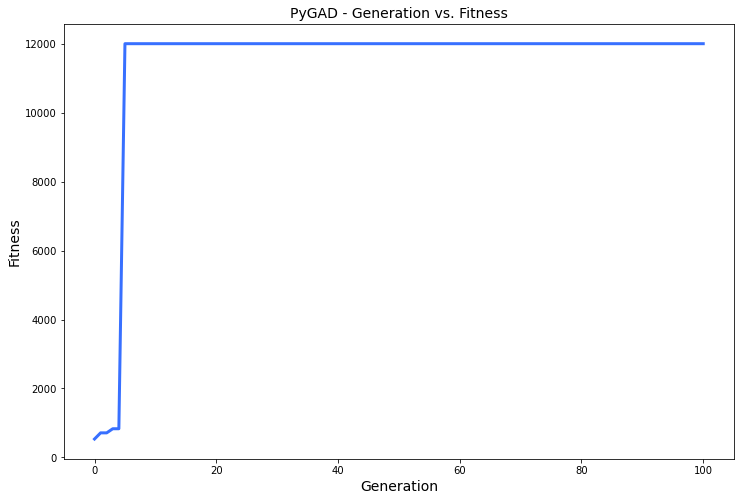

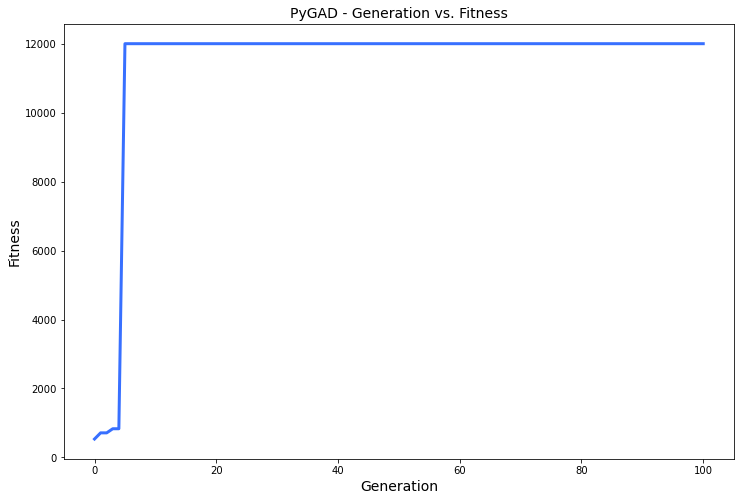

In [11]:
ga_instance.plot_result()

In [12]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 26.504 |==================| 27.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.994 |===========| 26.462 |==================| 12.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.468 |==================| 13.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 26.475 |==================| 15.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 |==================| 15.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==========

In [13]:
# Check the model's prediction
prediction = numpy.sum(numpy.array(water_model.FUNCTION_INPUTS)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))


Predicted output based on the best solution :0.2502615687275854
Best fitness value reached after 5 generations.


In [14]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,'N6']
print(presssure_at_N6)

0    26.540275
Name: N6, dtype: float64


In [56]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,'N6']
print(presssure_at_N6)

0    26.540275
Name: N6, dtype: float64


In [17]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model.TEMP_DIR}GENERATION_*")

water_model = WaterLeakModel(node='N6')
water_model.export_results(solutions = solution_per_generation, path='results', name='optimization-result-per-generation')
result_generation = pd.read_csv('results/optimization-result-per-generation.csv')
result_generation

File Exported Successfully to path: results/optimization-result-per-generation.csv


,GENERATION,FITNESS
0,13.0,12008.27882
1,12.0,12008.27882
2,38.0,12008.27882
3,10.0,12008.27882
4,9.0,12008.27882
...,...,...
95,37.0,12008.27882
96,6.0,12008.27882
97,7.0,12008.27882
98,36.0,12008.27882


In [27]:
fitness_solution_per_population = glob.glob(f"{water_model.TEMP_DIR}FITNESS_SOLUTION_*")
water_model.export_results(solutions = fitness_solution_per_population, path='results', name='optimization-result-per-fitness')
fitness_solution_per_population = pd.read_csv('results/optimization-result-per-fitness.csv')
fitness_solution_per_population

File Exported Successfully to path: results/optimization-result-per-fitness.csv


,EMITTER_COEFFICIENT_SOLUTION,OUTPUT,OUTPUT_DEMAND,FITNESS
0,0.128186,26.598248,10.1,17.273565
1,1.399839,26.395593,10.1,6.907710
2,0.422893,26.552457,10.1,82.641488
3,0.527651,26.536006,10.1,229.778472
4,1.349024,26.403940,10.1,7.330382
...,...,...,...,...
1916,0.383176,26.558670,10.1,54.603978
1917,0.349975,26.563854,10.1,42.557504
1918,0.193406,26.588177,10.1,20.911549
1919,1.329254,26.407182,10.1,7.508829


In [19]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='right')
final_data

,EMITTER_COEFFICIENT_SOLUTION,OUTPUT,OUTPUT_DEMAND,FITNESS,GENERATION
0,0.500523,26.540275,10.1,12008.27882,13.0
1,0.500523,26.540275,10.1,12008.27882,12.0
2,0.500523,26.540275,10.1,12008.27882,38.0
3,0.500523,26.540275,10.1,12008.27882,10.0
4,0.500523,26.540275,10.1,12008.27882,9.0
...,...,...,...,...,...
95,0.500523,26.540275,10.1,12008.27882,37.0
96,0.500523,26.540275,10.1,12008.27882,6.0
97,0.500523,26.540275,10.1,12008.27882,7.0
98,0.500523,26.540275,10.1,12008.27882,36.0


In [20]:
final_data.describe()

,EMITTER_COEFFICIENT_SOLUTION,OUTPUT,OUTPUT_DEMAND,FITNESS,GENERATION
count,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,0.500528,26.540274,1.010000e+01,11558.763728,50.500000
std,0.001668,0.000262,1.606775e-14,2213.291971,29.011492
min,0.492344,26.538951,1.010000e+01,710.589577,1.000000
25%,0.500523,26.540275,1.010000e+01,12008.278820,25.750000
50%,0.500523,26.540275,1.010000e+01,12008.278820,50.500000
75%,0.500523,26.540275,1.010000e+01,12008.278820,75.250000
max,0.508941,26.541561,1.010000e+01,12008.278820,100.000000


In [21]:
# Check if there are missing values after optimization?
final_data.isna().sum()

EMITTER_COEFFICIENT_SOLUTION    0
OUTPUT                          0
OUTPUT_DEMAND                   0
FITNESS                         0
GENERATION                      0
dtype: int64

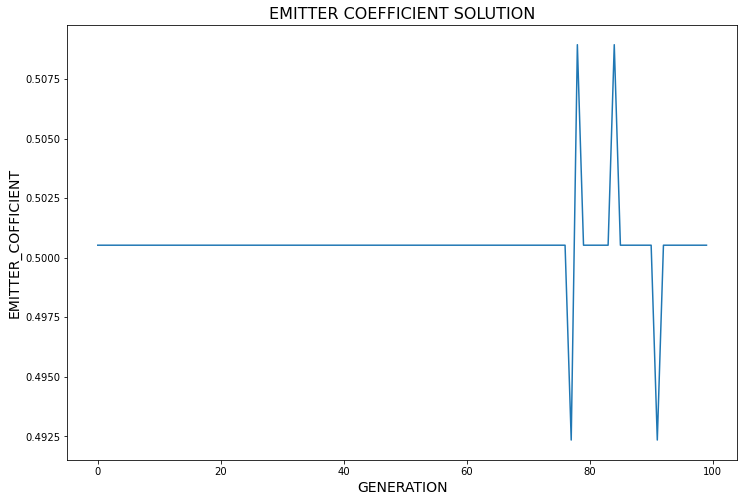

<Figure size 864x576 with 0 Axes>

In [85]:
plt.plot(final_data['EMITTER_COEFFICIENT_SOLUTION'])

plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT SOLUTION',fontsize=16)
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/EMITTER_COEFFICIENT.png");

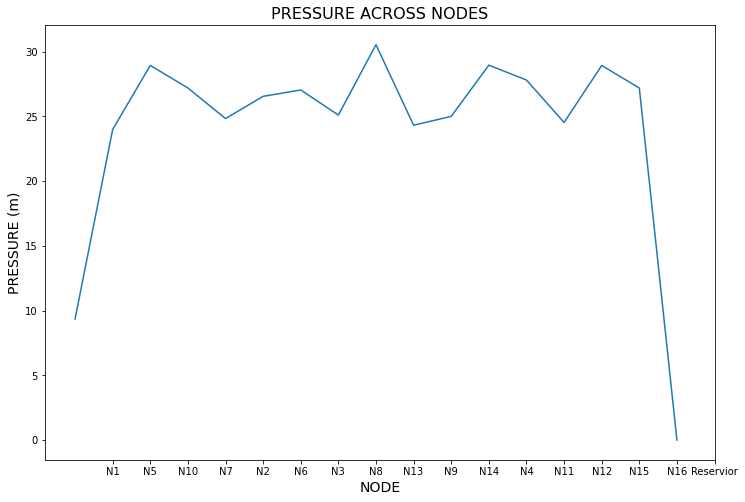

In [86]:
x = list(range(1,len(list(pressure.columns))+1))
plt.plot(list(pressure.values[0,:]))
plt.xlabel('NODE',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE ACROSS NODES',fontsize=16)
plt.xticks(x,list(pressure.columns))
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/Pressure.png")
plt.close()

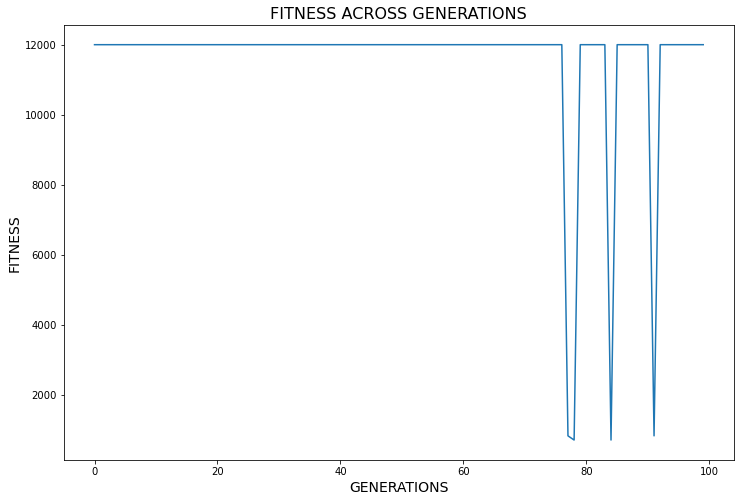

In [87]:
plt.plot(final_data['FITNESS'])
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/FITNESS_GEN.png")
plt.close()

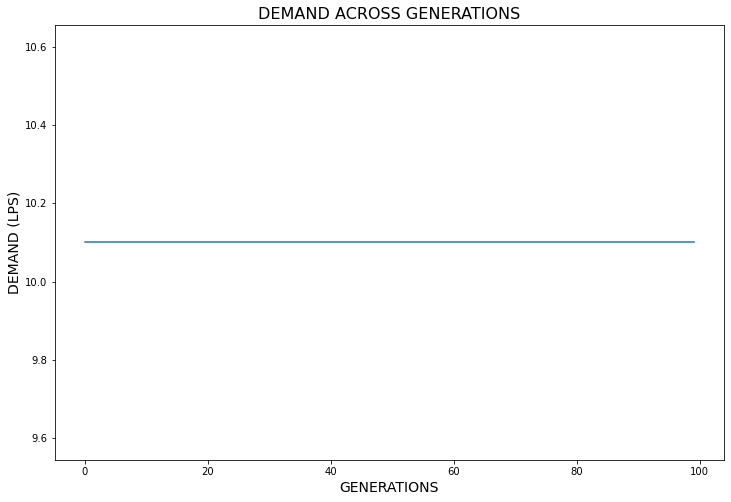

In [88]:
plt.plot(final_data['OUTPUT_DEMAND'])
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/DEMAND_VS_GEN.png")
plt.close()